In [1]:
# use geo_env_2022

import os
import numpy as np
import pandas as pd # original 1.2.3
import geopandas as gpd
from shapely.geometry import Point
import pickle
import urllib.request

In [2]:
def get_prio_shape():

    location = '/home/simon/Documents/Bodies/data/PRIO'
    path_prio = location + '/priogrid_shapefiles.zip'

    if os.path.isfile(path_prio) == True:
        
        print('File already downloaded')
        prio_grid = gpd.read_file('zip://' + path_prio)

    else:
        print('Beginning file download PRIO...')
        url_prio = 'http://file.prio.no/ReplicationData/PRIO-GRID/priogrid_shapefiles.zip'

        urllib.request.urlretrieve(url_prio, path_prio)
        prio_grid = gpd.read_file('zip://' + path_prio)

    return prio_grid


def get_gwno():

    location = '/home/simon/Documents/Bodies/data/PRIO'
    path_gwno = location + '/PRIO-GRID Yearly Variables for 1989-2014 - 2022-06-16.csv' #https://grid.prio.org/#/download Simply contains the GW contry code and the meta.

    # why not just go 1989 - 2019 like ucdp...

    gwno = pd.read_csv(path_gwno)

    return gwno


def get_ucdp():
    location = '/home/simon/Documents/Bodies/data/UCDP' 
    path_ucdp = location + "/ged201-csv.zip"
    
    if os.path.isfile(path_ucdp) == True:
        print('file already downloaded')
        ucdp = pd.read_csv(path_ucdp)


    else: 
        print('Beginning file download UCDP...')

        url_ucdp = 'https://ucdp.uu.se/downloads/ged/ged201-csv.zip'
    
        urllib.request.urlretrieve(url_ucdp, path_ucdp)
        ucdp = pd.read_csv(path_ucdp)

    return ucdp


In [3]:
# something like get_gwno for the other stuff Jacob want

In [4]:

def add_months(ucdp, world_grid):

    diff = ucdp['year'].max() - world_grid['year'].max()

    subset_list = []

    for i in np.arange(1, diff+1, 1):

        subset = world_grid[world_grid['year'] == world_grid['year'].max()].copy()
        subset['year'] = world_grid['year'].max() + i

        subset_list.append(subset)

    new_years = pd.concat(subset_list)
    world_grid_all_years = pd.concat([world_grid, new_years])

    month = [str(i).zfill(2) for i in np.arange(1,13,1)]
    world_grid_all_years.loc[:,'month'] = world_grid_all_years.apply(lambda _: month, axis=1)
    world_grid_all_months = world_grid_all_years.sort_values('year').explode('month').copy()
    world_grid_all_months['year_months_start'] =  world_grid_all_months['year'].astype(str) + '-' +  world_grid_all_months['month'].astype(str)

    year_months = sorted(world_grid_all_months['year_months_start'].unique())
    ts = len(year_months)
    month_ids = np.arange(109, ts + 109, 1)
    month_id_dict = dict(zip(year_months,month_ids))
    month_df = pd.DataFrame({'year_months_start' : year_months, 'month_id': month_ids})
    world_grid_all_months_id = world_grid_all_months.merge(month_df, how = 'left', on = 'year_months_start')

    return world_grid_all_months_id

In [5]:

def prio_ucdp_merge(ucdp, world_grid_all_months):
    ucdp_tmp1 = ucdp.copy()

    ucdp_tmp1['year_months_start'] = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7) # Date YYYY-MM-DD
    ucdp_tmp1['year_months_end'] = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7) # Date YYYY-MM-DD


    mask1 = (ucdp_tmp1['year'] != ucdp_tmp1['year_months_start'].str.slice(start = 0, stop = 4).astype(int))
    mask2 = (ucdp_tmp1['year'] != ucdp_tmp1['year_months_end'].str.slice(start = 0, stop = 4).astype(int))

    # correction. Note that end and start year for the four entries that is corrected is the same.
    ucdp_tmp1.loc[mask1 | mask2, 'year'] = ucdp_tmp1.loc[mask1 | mask2,'year_months_start'].str.slice(start = 0, stop = 4).astype(int)

    feature_list = ['deaths_a','deaths_b', 'deaths_civilians', 'deaths_unknown','best', 'high', 'low']

    ucdp_monthly_unit = ucdp_tmp1.groupby(['year_months_start','year', 'priogrid_gid']).sum()[feature_list].reset_index()
    ucdp_monthly_unit.rename(columns={'priogrid_gid':'gid'}, inplace=True)

    ucdp_monthly_unit['log_best'] = np.log(ucdp_monthly_unit['best'] +1)
    ucdp_monthly_unit['log_low'] = np.log(ucdp_monthly_unit['low'] +1)
    ucdp_monthly_unit['log_high'] = np.log(ucdp_monthly_unit['high'] +1)

    prio_ucdp_df = world_grid_all_months.merge(ucdp_monthly_unit, how = 'left', on = ['gid', 'year_months_start', 'year'])
    prio_ucdp_df.fillna(0, inplace=True)

    return prio_ucdp_df


In [6]:
# prio_grid = get_prio_shape()
# gwno = get_gwno()
# ucdp = get_ucdp()

# world_grid = prio_grid.merge(gwno, how = 'right', on = 'gid') # if you just merge this on outer I think you get the full grid needed for R-UNET
# world_grid_all_months = add_months(ucdp, world_grid)
# prio_ucdp = prio_ucdp_merge(ucdp, world_grid_all_months)

In [7]:
def compile_combined_df():

    prio_grid = get_prio_shape()
    gwno = get_gwno()
    ucdp = get_ucdp()

    world_grid = prio_grid.merge(gwno, how = 'right', on = 'gid') # if you just merge this on outer I think you get the full grid needed for R-UNET
    world_grid_all_months = add_months(ucdp, world_grid)
    prio_ucdp = prio_ucdp_merge(ucdp, world_grid_all_months)

    data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

    with open(f'{data_dir}g_df_ucdp_prio.pkl', 'wb') as file:
        pickle.dump(prio_ucdp, file)

    prio_ucdp_pd = pd.DataFrame(prio_ucdp.drop(columns= 'geometry').copy())

    with open(f'{data_dir}df_ucdp_prio.pkl', 'wb') as file:
        pickle.dump(prio_ucdp_pd, file)


if __name__ == "__main__":
    compile_combined_df()


File already downloaded
file already downloaded


/tmp/ipykernel_2751511/1529523153.py:39: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  ucdp = pd.read_csv(path_ucdp)


# Checking

In [8]:
data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

# with open(f'{data_dir}bodies_df_fatal.pkl', 'rb') as file:
#     bodies_df_fatal = pickle.load(file)

with open(f'{data_dir}df_ucdp_prio.pkl', 'rb') as file:
    prio_ucdp = pickle.load(file)

test_df = prio_ucdp.drop(['deaths_a', 'deaths_b', 'deaths_civilians', 'deaths_unknown'], axis = 1).copy()

In [9]:
data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

# with open(f'{data_dir}bodies_df_fatal.pkl', 'rb') as file:
#     bodies_df_fatal = pickle.load(file)

with open(f'{data_dir}df_ucdp_prio_old.pkl', 'rb') as file:
    old_df = pickle.load(file)

In [10]:
for c in test_df.columns:
    eq = old_df[c].equals(test_df[c])
    print(f'{c}: {eq}')

gid: True
xcoord: True
ycoord: True
col: True
row: True
year: True
gwno: True
month: True
year_months_start: True
month_id: True
best: True
high: True
low: True
log_best: True
log_low: True
log_high: True


In [11]:
data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

# with open(f'{data_dir}bodies_df_fatal.pkl', 'rb') as file:
#     bodies_df_fatal = pickle.load(file)

with open(f'{data_dir}bodies_df_exposure.pkl', 'rb') as file:
    bodies = pickle.load(file)

In [12]:
for i in bodies.columns:
    print(i)

person_mean
person_median
person_fasterR50
person_fasterR101
person_fasterX101
person_retinaR50
person_retinaR101
child_mean
child_median
child_retinaR50
child_retinaR101
male_mean
male_median
male_fasterR50
male_fasterR101
male_fasterX101
male_retinaR50
male_retinaR101
adult_mean
adult_median
adult_fasterR50
adult_fasterR101
adult_fasterX101
adult_retinaR50
adult_retinaR101
youth_mean
youth_median
youth_retinaR50
youth_retinaR101
falgIRQ_mean
falgIRQ_median
falgIRQ_fasterR50
falgIRQ_fasterR101
falgIRQ_fasterX101
falgIRQ_retinaR50
falgIRQ_retinaR101
female_mean
female_median
female_retinaR50
female_retinaR101
religiousGarmentFemale_mean
religiousGarmentFemale_median
religiousGarmentFemale_retinaR50
religiousGarmentFemale_retinaR101
uniformed_mean
uniformed_median
uniformed_fasterR50
uniformed_fasterR101
uniformed_fasterX101
uniformed_retinaR50
uniformed_retinaR101
firearm_mean
firearm_median
firearm_fasterR50
firearm_fasterR101
firearm_fasterX101
firearm_retinaR50
firearm_retinaR101
fl

In [13]:
import matplotlib.pyplot as plt

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
country_mask_world = ['Israel', 'Palestine', 'Jordan', 'Iraq', 'Syria', 'Turkey', 'Lebanon']
sub_world = world[world['name'].isin(country_mask_world)].copy()


gwno_list = [645., 652., 663., 666., 640., 660.]
sub_prio_ucdp = prio_ucdp[(prio_ucdp['month_id'] == 480) & (prio_ucdp['gwno'].isin(gwno_list))]

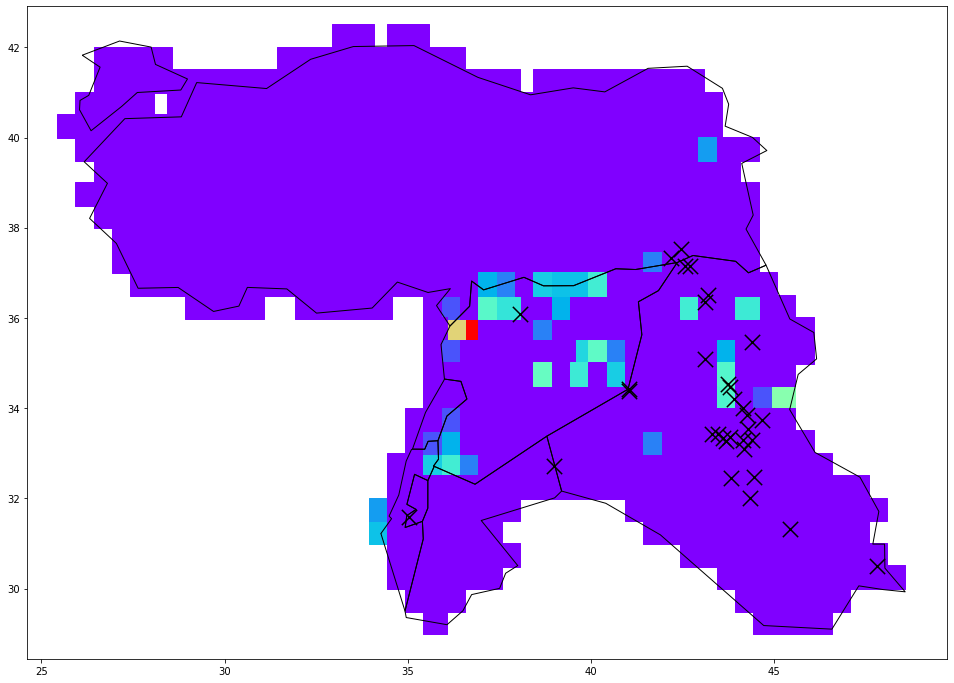

In [14]:
#plt.figure(figsize = [14,8])
fig, ax = plt.subplots(figsize = (20,12))
ax.set_aspect('equal')

plt.scatter(sub_prio_ucdp['xcoord'], sub_prio_ucdp['ycoord'], c = np.log(sub_prio_ucdp['best']+1), cmap = 'rainbow', marker = 's', s = 560)
plt.scatter(bodies['longitude_full'].unique()[:-1], bodies['latitude_full'].unique()[:-1], color = 'black', marker = 'x', s = 235)
sub_world.plot(facecolor='none', edgecolor='black', ax=ax)


plt.show()

# Why some features that might be interesting are not here:

Fra Uppsala:

- event_clarity 
- date_prec 
- type_of_violence

Fra Prio

